In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=d266dc219d10cb9a636791e341f34287e4d7438472c1d14bb48c9814ff9d6828
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=be1eebdf38c903c05c6e2282f4c46d1fbfd5b59a3266306d93da15a067966715
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumenta

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/Road_seg_dataset2')

In [4]:
import torch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import helper

In [5]:
CSV_FILE = "/content/drive/MyDrive/AprendizajeEstadistico/Proyecto/Road_seg_dataset2/train.csv" # dir Cesar

DATA_DIR="/content/drive/MyDrive/AprendizajeEstadistico/Proyecto/Road_seg_dataset2/" # dir Cesar
#DATA_DIR="/content/drive/MyDrive/tmp_proyecto/Road_seg_dataset/" # dir Profesor



DEVICE="cuda"
EPOCH=100
LR=0.01
BATCH_SIZE=1
IMG_SIZE=256

ENCODER="timm-efficientnet-b0"
WEIGHTS="imagenet"

In [6]:
df=pd.read_csv(CSV_FILE)
df

,images,masks
0,images/0.bmp,masks/0.bmp
1,images/1.bmp,masks/1.bmp
2,images/2.bmp,masks/2.bmp
3,images/3.bmp,masks/3.bmp
4,images/4.bmp,masks/4.bmp
...,...,...
1995,images/1995.bmp,masks/1995.bmp
1996,images/1996.bmp,masks/1996.bmp
1997,images/1997.bmp,masks/1997.bmp
1998,images/1998.bmp,masks/1998.bmp


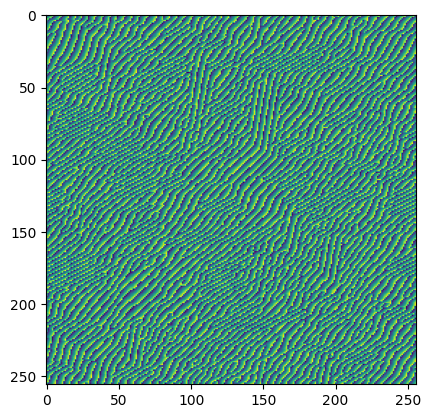

In [7]:
im=plt.imread(DATA_DIR+df.masks[0])
plt.imshow(im)

In [8]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

In [9]:
from torch.utils.data import Dataset

In [10]:
import albumentations as A
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=5),
      A.HorizontalFlip(p=5)
  ])
def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

class SegmentationDataset(Dataset):
  def __init__(self, df, augmentation):
    self.df=df
    self.augmentation=augmentation

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row=df.iloc[idx]


    image_path=DATA_DIR+row.images
    mask_path=DATA_DIR+row.masks

    image=cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    mask=cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h,v)

    # image = np.transpose(image, (2,0,1)).astype(np.float32)#(c,h,w)
    # mask = np.transpose(mask, (2,0,1)).astype(np.float32)#(c,h,w)

    image=torch.Tensor(image)/255
    mask=torch.Tensor(mask)/255
    #mask=torch.round(torch.Tensor(mask)/255)
    return image, mask


In [11]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [12]:
from torch.utils.data import DataLoader

In [13]:
trainloader=DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader=DataLoader(validset, batch_size=BATCH_SIZE)

In [14]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torch import nn

In [15]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone=smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=1,
        classes=1,
        activation=None
    )


  def forward(self, images, masks=None):
    # Asegurarse de que images tiene 4 dimensiones
    if images.dim() == 3:
        images = images.unsqueeze(0)

    logits = self.backbone(images)
    mse_loss = nn.MSELoss()

    if masks is not None:
        # Asegurarse de que masks también tiene 4 dimensiones si es necesario
        if masks.dim() == 3:
            masks = masks.unsqueeze(0)

        # return logits, DiceLoss(mode="binary")(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)
        return logits, mse_loss(logits, masks)

    return logits

In [16]:
model=SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 150MB/s]


SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

In [17]:
def train_fn(dataloader, model, optimizer):
  model.train()#Turn on dropout, batchnomr, et
  total_loss = 0.0

  for images, masks in tqdm(dataloader):
    images=images.to(DEVICE)
    masks=masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss=model(images, masks )
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()
  return total_loss/len(dataloader)

def eval_fn(dataloader, model):
  model.eval()#Turn on dropout, batchnomr, et
  total_loss=0.0
  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images=images.to(DEVICE)
      masks=masks.to(DEVICE)


      logits, loss=model(images, masks )

      total_loss+=loss.item()
  return total_loss/len(dataloader)

In [18]:
DEVICE="cuda"
optimizer=torch.optim.Adam(model.parameters(), lr=LR)

In [19]:
best_loss=np.Inf
loss_train = []
loss_test = []
for i in range(EPOCH):
  train_loss=train_fn(trainloader, model, optimizer)
  valid_loss=eval_fn(validloader, model)


  if(valid_loss<best_loss):
    # torch.save(model.state_dict(), "best-model.pt")
    torch.save(model, "best-model.pt")
    print("SAVED MODEL")
    best_loss=valid_loss
    loss_train.append(train_loss)
    loss_test.append(valid_loss)

  print(f"Epoch:{i+1} train loss:{train_loss} valid loss:{valid_loss}")

100%|██████████| 400/400 [00:08<00:00, 48.93it/s]


SAVED MODEL
Epoch:1 train loss:0.086098797544837 valid loss:0.08332518618553877


100%|██████████| 400/400 [00:08<00:00, 47.14it/s]


SAVED MODEL
Epoch:2 train loss:0.08340004557743669 valid loss:0.08331146301701665


100%|██████████| 400/400 [00:07<00:00, 55.73it/s]


Epoch:3 train loss:0.08337397508323192 valid loss:0.08344507602974773


100%|██████████| 400/400 [00:08<00:00, 48.90it/s]


Epoch:4 train loss:0.08334996609017253 valid loss:0.08331525357440114


100%|██████████| 400/400 [00:07<00:00, 55.48it/s]


SAVED MODEL
Epoch:5 train loss:0.08330617144703865 valid loss:0.08329555656760931


100%|██████████| 400/400 [00:08<00:00, 48.86it/s]


SAVED MODEL
Epoch:6 train loss:0.08286768040619791 valid loss:0.08222471358254552


100%|██████████| 400/400 [00:07<00:00, 55.72it/s]


SAVED MODEL
Epoch:7 train loss:0.08140715884044766 valid loss:0.0810068086348474


100%|██████████| 400/400 [00:08<00:00, 48.74it/s]


SAVED MODEL
Epoch:8 train loss:0.0806802242109552 valid loss:0.08051302686333656


100%|██████████| 400/400 [00:07<00:00, 55.91it/s]


SAVED MODEL
Epoch:9 train loss:0.08043689467478543 valid loss:0.08039440158754588


100%|██████████| 400/400 [00:08<00:00, 48.15it/s]


SAVED MODEL
Epoch:10 train loss:0.0802975042676553 valid loss:0.08035174202173949


100%|██████████| 400/400 [00:07<00:00, 55.57it/s]


Epoch:11 train loss:0.08020241209305823 valid loss:0.08051116852089762


100%|██████████| 400/400 [00:08<00:00, 48.92it/s]


Epoch:12 train loss:0.08015322128776461 valid loss:0.08070407943800091


100%|██████████| 400/400 [00:07<00:00, 55.53it/s]


Epoch:13 train loss:0.08010198528878391 valid loss:0.0805316686630249


100%|██████████| 400/400 [00:08<00:00, 48.23it/s]


Epoch:14 train loss:0.08008746678009629 valid loss:0.08151955241337419


100%|██████████| 400/400 [00:07<00:00, 55.44it/s]


SAVED MODEL
Epoch:15 train loss:0.08005262652412057 valid loss:0.08018639167770743


100%|██████████| 400/400 [00:08<00:00, 48.24it/s]


Epoch:16 train loss:0.08000902917701751 valid loss:0.08111800888553261


100%|██████████| 400/400 [00:07<00:00, 55.86it/s]


Epoch:17 train loss:0.0799830160709098 valid loss:0.08145786723122


100%|██████████| 400/400 [00:08<00:00, 47.41it/s]


SAVED MODEL
Epoch:18 train loss:0.07994928134139627 valid loss:0.08004237027838826


100%|██████████| 400/400 [00:07<00:00, 53.96it/s]


Epoch:19 train loss:0.07992305293213577 valid loss:0.08030791325494648


100%|██████████| 400/400 [00:08<00:00, 49.89it/s]


Epoch:20 train loss:0.07989339318592101 valid loss:0.08041360579431057


100%|██████████| 400/400 [00:08<00:00, 48.70it/s]


Epoch:21 train loss:0.07987683417275548 valid loss:0.08126587009057402


100%|██████████| 400/400 [00:07<00:00, 54.18it/s]


Epoch:22 train loss:0.07986870205495507 valid loss:0.08023000817745923


100%|██████████| 400/400 [00:08<00:00, 47.31it/s]


Epoch:23 train loss:0.0798488906538114 valid loss:0.08130451247096061


100%|██████████| 400/400 [00:07<00:00, 53.47it/s]


Epoch:24 train loss:0.07982945550698788 valid loss:0.08175783297047019


100%|██████████| 400/400 [00:07<00:00, 50.36it/s]


SAVED MODEL
Epoch:25 train loss:0.07982383440248668 valid loss:0.07995048146694898


100%|██████████| 400/400 [00:08<00:00, 48.71it/s]


Epoch:26 train loss:0.07980477752629668 valid loss:0.08021577872335911


100%|██████████| 400/400 [00:07<00:00, 54.97it/s]


Epoch:27 train loss:0.07978587677236647 valid loss:0.07995264481753112


100%|██████████| 400/400 [00:08<00:00, 47.91it/s]


Epoch:28 train loss:0.0797879375750199 valid loss:0.08145015625283122


100%|██████████| 400/400 [00:07<00:00, 55.34it/s]


SAVED MODEL
Epoch:29 train loss:0.07977387188933789 valid loss:0.07991512889042497


100%|██████████| 400/400 [00:08<00:00, 48.03it/s]


Epoch:30 train loss:0.07977154242340476 valid loss:0.08102079154923558


100%|██████████| 400/400 [00:07<00:00, 55.94it/s]


Epoch:31 train loss:0.07985617636237294 valid loss:0.07996974270790816


100%|██████████| 400/400 [00:08<00:00, 48.34it/s]


Epoch:32 train loss:0.0798103252844885 valid loss:0.07998743262141943


100%|██████████| 400/400 [00:07<00:00, 54.04it/s]


Epoch:33 train loss:0.07979245453607291 valid loss:0.08068353733047844


100%|██████████| 400/400 [00:08<00:00, 49.34it/s]


SAVED MODEL
Epoch:34 train loss:0.07978984722867608 valid loss:0.07983511079102755


100%|██████████| 400/400 [00:07<00:00, 54.40it/s]


Epoch:35 train loss:0.07977900023572147 valid loss:0.08109611704945564


100%|██████████| 400/400 [00:08<00:00, 49.28it/s]


Epoch:36 train loss:0.07976963562425227 valid loss:0.0813333784416318


100%|██████████| 400/400 [00:07<00:00, 51.81it/s]


Epoch:37 train loss:0.07974815788678825 valid loss:0.08002036355435849


100%|██████████| 400/400 [00:07<00:00, 51.94it/s]


Epoch:38 train loss:0.0797516450798139 valid loss:0.08121950726956129


100%|██████████| 400/400 [00:07<00:00, 52.32it/s]


SAVED MODEL
Epoch:39 train loss:0.07972476334776729 valid loss:0.0797759666480124


100%|██████████| 400/400 [00:07<00:00, 50.89it/s]


Epoch:40 train loss:0.07971509950235486 valid loss:0.07983067777007818


100%|██████████| 400/400 [00:07<00:00, 53.10it/s]


Epoch:41 train loss:0.07971132779028267 valid loss:0.0802630521543324


100%|██████████| 400/400 [00:07<00:00, 55.08it/s]


Epoch:42 train loss:0.07970321727916599 valid loss:0.08060048948973417


100%|██████████| 400/400 [00:08<00:00, 49.99it/s]


Epoch:43 train loss:0.07970272286329419 valid loss:0.08006504405289888


100%|██████████| 400/400 [00:07<00:00, 54.00it/s]


Epoch:44 train loss:0.07967647936195135 valid loss:0.08023652378469706


100%|██████████| 400/400 [00:07<00:00, 50.00it/s]


Epoch:45 train loss:0.07966776709072292 valid loss:0.08035577166825533


  5%|▌         | 85/1600 [00:31<09:20,  2.70it/s]


KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Loss Entrenamiento. lr = 0.01, epocs = 100, BS = 1')

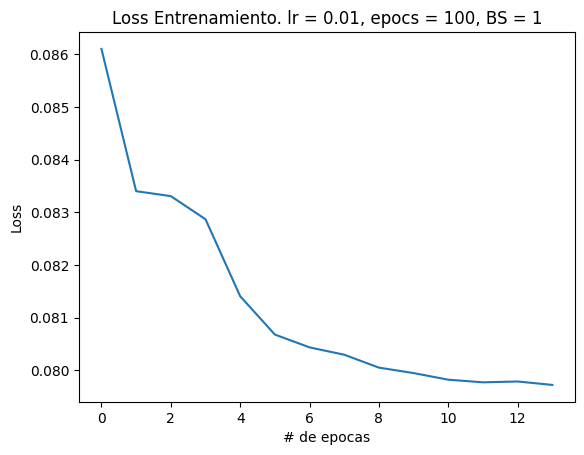

In [20]:
array_epochs = np.arange(1, EPOCH+1,1)
plt.plot( loss_train)
plt.xlabel('# de epocas')
plt.ylabel('Loss')
plt.title(f'Loss Entrenamiento. lr = {LR}, epocs = {EPOCH}, BS = {BATCH_SIZE}')

Text(0.5, 1.0, 'Loss Test. lr = 0.01, epocs = 100, BS = 1')

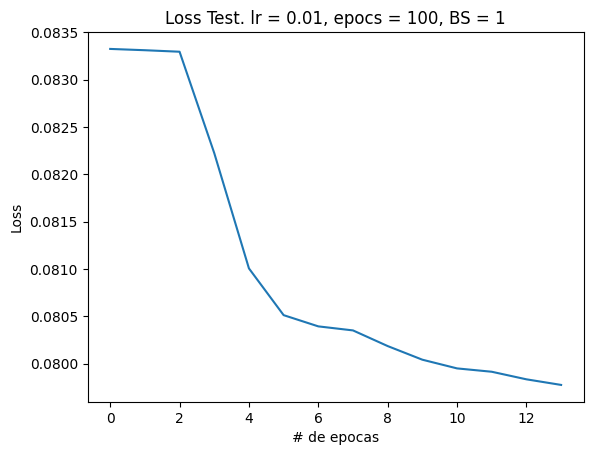

In [21]:
plt.plot(loss_test)
plt.xlabel('# de epocas')
plt.ylabel('Loss')
plt.title(f'Loss Test. lr = {LR}, epocs = {EPOCH}, BS = {BATCH_SIZE}')

In [22]:
model = torch.load('best-model.pt')
model.eval()

SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
from PIL import Image as im
size = 256
folder_path1 = '/content/drive/My Drive/AprendizajeEstadistico/Proyecto/'
R = im.open(folder_path1+ f"prueba2.bmp") # Se abre la imagen
R = R.convert('L') # Se asegura que este en escala de grises
R = R.resize((size, size)) # Se redimensiona al tamaño de la red
R = np.asarray(R) # Se convierte en array de numpy
R = R/255 # Se normaliza
R = torch.Tensor(R)
input_data = R.unsqueeze(0)
input_data = input_data.to('cuda')  # Mover datos de entrada a la GPU

In [25]:
with torch.no_grad():
    output = model(input_data)

In [26]:
a = output.squeeze(0)
output = a.squeeze(0)

In [27]:
# Mover el tensor a la CPU si está en GPU
tensor = output.to('cpu')

# Desvincular el tensor del grafo de computación si es necesario
tensor = tensor.detach()

In [28]:
numpy_array = tensor.numpy()


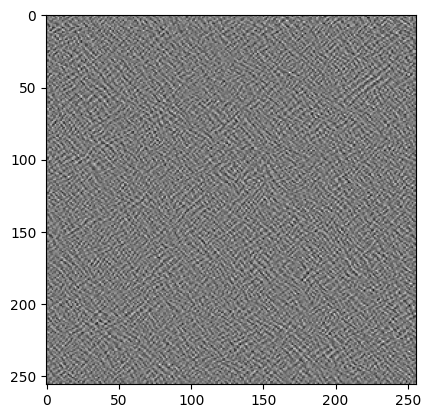

In [29]:
plt.imshow(numpy_array, cmap='gray')

In [30]:
# Encontrar el mínimo y el máximo
min_val = numpy_array.min()
max_val = numpy_array.max()

# Normalizar la matriz
matriz_normalizada = (numpy_array - min_val) / (max_val - min_val)

In [31]:
# Escalar la matriz al rango 0-255 y convertirla a uint8
imagen = (matriz_normalizada * 255).astype(np.uint8)

# Convertir la matriz a un objeto de imagen de Pillow
imagen_pil = im.fromarray(imagen)

# Guardar la imagen en formato BMP
imagen_pil.save("imagen_red2.bmp")